# Modelo
En este notebook crearemos y entrenaremos un clasificador en el conjunto de datos de radiografías de tórax para clasificar si una imagen muestra signos de neumonía o no.


**Importaciones**:

* `torch` y `torchvision` para la creación del modelo y los dataloaders.
* `transforms` de `torchvision` para la Augmentación de Datos y Normalización.
* `torchmetrics` para una fácil computación de métricas.
* `pytorch_lightning` para una implementación de entrenamiento eficiente y sencilla.
* `ModelCheckpoint` y `TensorBoardLogger` para guardar puntos de control (checkpoints) y registro de datos.
* `tqdm` para la barra de progreso al validar el modelo.
* `numpy` para todo tipo de operaciones :)
* `matplotlib` para visualizar algunas imágenes.


In [3]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Primero, creamos nuestro conjunto de datos. Podemos aprovechar **DatasetFolder** de `torchvision`: nos permite simplemente pasar un directorio raíz y devolver un objeto de conjunto de datos con acceso a todos los archivos dentro del directorio, utilizando el nombre del directorio como etiqueta de clase. <br />
Solo necesitamos definir una función de carga, **load_file**, que especifique cómo se deben cargar los archivos. Esto es muy cómodo, ya que solo tenemos que cargar nuestros archivos previamente almacenados en formato numpy. 

Además, necesitamos definir una lista de extensiones de archivo (en nuestro caso, solo "npy").

Finalmente, podemos pasar una secuencia de transformaciones para la Augmentación de Datos y Normalización.

Usamos:
* **RandomResizedCrops**, que aplica un recorte aleatorio de la imagen y la redimensiona al tamaño original de la imagen (224x224).
* **Rotaciones aleatorias** entre -5 y 5 grados.
* **Traslación aleatoria** (máximo 5%).
* **Escalado aleatorio** (0.9-1.1 del tamaño original de la imagen).

In [11]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),  # Convierte el arreglo numpy a tensor
    transforms.Normalize(0.49, 0.248),  # Normaliza usando la media y desviación estándar del notebook de preprocesamiento
    transforms.RandomAffine(  # Data Augmentation
        degrees=(-5, 5),  # Aplica rotaciones aleatorias entre -5 y 5 grados
        translate=(0, 0.05),  # Aplica traslación aleatoria con un máximo del 5%
        scale=(0.9, 1.1)  # Escala aleatoriamente la imagen entre 90% y 110% de su tamaño original
    ),
    transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))  # Aplica un recorte aleatorio y redimensiona a 224x224 píxeles
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),  # Convierte el arreglo numpy a tensor
    transforms.Normalize([0.49], [0.248])  # Normaliza usando la media y desviación estándar del notebook de preprocesamiento
])

Finalmente, creamos el conjunto de datos de entrenamiento y validación, junto con los respectivos cargadores de datos (data loaders).

Por favor, adapta el tamaño del lote (batch size) y el número de trabajadores (num_workers) de acuerdo con los recursos de tu hardware.

In [12]:
import os
from torchvision import datasets
from utils import load_file

# Obtener las rutas de los conjuntos de datos (datasets) desde las variables de entorno
train_dataset_path = 'data/Processed/train'
val_dataset_path = 'data/Processed/val'

# Asegurarse de que las rutas se hayan cargado correctamente desde el archivo .env
if train_dataset_path is None or val_dataset_path is None:
    raise ValueError("Las rutas de los datasets no están definidas en el archivo .env.")

# Crear el conjunto de datos de entrenamiento usando la ruta obtenida y la función de carga
train_dataset = datasets.DatasetFolder(
    train_dataset_path,  # Ruta al directorio de los datos de entrenamiento
    loader=load_file,  # Función personalizada para cargar los archivos
    extensions="npy",  # Especificar las extensiones de archivo a cargar (en este caso, archivos .npy)
    transform=train_transforms  # Aplicar las transformaciones definidas para los datos de entrenamiento
)

# Crear el conjunto de datos de validación usando la ruta obtenida y la función de carga
val_dataset = datasets.DatasetFolder(
    val_dataset_path,  # Ruta al directorio de los datos de validación
    loader=load_file,  # Función personalizada para cargar los archivos
    extensions="npy",  # Especificar las extensiones de archivo a cargar (en este caso, archivos .npy)
    transform=val_transforms  # Aplicar las transformaciones definidas para los datos de validación
)

### Imagenes despues del Data Augmentation

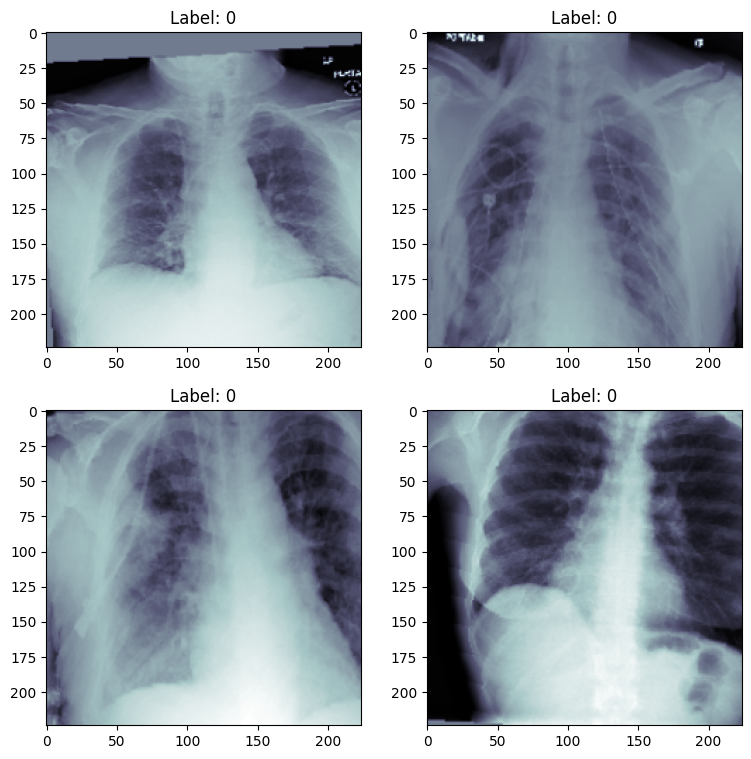

In [13]:
# Inspeccionemos algunas imágenes aumentadas del conjunto de entrenamiento
fig, axis = plt.subplots(2, 2, figsize=(9, 9))  # Crear una cuadrícula de 2x2 para mostrar las imágenes, con un tamaño de figura de 9x9 pulgadas

for i in range(2):  # Iterar sobre las filas de la cuadrícula
    for j in range(2):  # Iterar sobre las columnas de la cuadrícula
        random_index = np.random.randint(0, 20000)  # Obtener un índice aleatorio entre 0 y 20000 para seleccionar una imagen del conjunto de datos de entrenamiento
        x_ray, label = train_dataset[random_index]  # Obtener la imagen y la etiqueta correspondientes al índice aleatorio
        axis[i][j].imshow(x_ray[0], cmap="bone")  # Mostrar la imagen en escala de grises ("bone" es un mapa de colores adecuado para rayos X)
        axis[i][j].set_title(f"Label: {label}")  # Establecer el título de la imagen, mostrando su etiqueta

In [14]:
batch_size = 64  # Tamaño del lote (batch size), es decir, el número de muestras que se procesarán juntas en cada iteración
num_workers = 4  # Número de trabajadores (workers) para cargar los datos en paralelo, lo que puede acelerar el proceso

# Crear el DataLoader para el conjunto de entrenamiento
train_loader = torch.utils.data.DataLoader(
    train_dataset,  # El conjunto de datos de entrenamiento
    batch_size=batch_size,  # Número de muestras por lote
    num_workers=num_workers,  # Número de procesos en paralelo para cargar los datos
    shuffle=True,  # Barajar los datos en cada época para mejorar la generalización
    persistent_workers=True  # Mantener los procesos de los trabajadores activos entre épocas para una carga más eficiente
)

# Crear el DataLoader para el conjunto de validación
val_loader = torch.utils.data.DataLoader(
    val_dataset,  # El conjunto de datos de validación
    batch_size=batch_size,  # Número de muestras por lote
    num_workers=num_workers,  # Número de procesos en paralelo para cargar los datos
    shuffle=False,  # No barajar los datos de validación, ya que no es necesario
    persistent_workers=True  # Mantener los procesos de los trabajadores activos entre épocas
)

# Imprimir el número de imágenes en los conjuntos de entrenamiento y validación
print(f"Tenemos {len(train_dataset)} imágenes de entrenamiento y {len(val_dataset)} imágenes de validación")

Tenemos 24000 imágenes de entrenamiento y 2684 imágenes de validación


Las clases están desequilibradas: hay más imágenes sin signos de neumonía que con neumonía.
Existen múltiples maneras de manejar conjuntos de datos desequilibrados

In [6]:
# Obtener los valores únicos y sus respectivas cantidades en las etiquetas del conjunto de entrenamiento y validación
# np.unique devuelve los valores únicos en un arreglo y return_counts=True hace que también devuelva la cantidad de veces que aparece cada valor
np.unique(train_dataset.targets, return_counts=True), np.unique(val_dataset.targets, return_counts=True)

((array([0, 1]), array([18593,  5407])), (array([0, 1]), array([2079,  605])))

## Creación del Modelo 

Cada modelo en PyTorch Lightning se define al menos por un método de inicialización, una función **forward** que define el paso hacia adelante/predicción, un **training_step** que calcula la pérdida y **configure_optimizers** para especificar el algoritmo de optimización.

Además, podemos usar un callback **training_epoch_end** para calcular estadísticas y métricas generales del conjunto de datos, como la precisión.

Posteriormente, definimos el **validation_step**. El paso de validación realiza prácticamente los mismos pasos que el paso de entrenamiento, pero en los datos de validación. En este caso, PyTorch Lightning no actualiza los pesos. Nuevamente, podemos usar **validation_epoch_end** para calcular las métricas generales del conjunto de datos.

No se necesitan bucles ni actualizaciones manuales de los pesos

Además, PyTorch Lightning también maneja la gestión de dispositivos. Solo es necesario pasar el número de GPUs al crear el entrenador.

Usaremos la arquitectura de la red ResNet18.

Como la mayoría de los modelos de `torchvision`, la ResNet original espera una entrada de tres canales en **conv1**.  
Sin embargo, nuestros datos de imágenes de rayos X tienen solo un canal.  
Por lo tanto, necesitamos cambiar el parámetro `in_channel` de 3 a 1.

Además, cambiaremos la última capa totalmente conectada para que tenga solo una salida, ya que tenemos una etiqueta de clase binaria.

### Optimizador y Función de Pérdida

Usamos el optimizador **Adam** con una tasa de aprendizaje de 0.0001 y la función de pérdida **BinaryCrossEntropy**.  
(De hecho, usamos **BCEWithLogitsLoss**, que acepta directamente los valores predichos sin procesar y calcula la función de activación sigmoide antes de aplicar la Entropía Cruzada).

Si lo deseas, puedes asignar un peso diferente de 1 al modelo de neumonía para utilizar la función de pérdida ponderada.


In [5]:
# Definición de la clase del modelo de neumonía usando PyTorch Lightning
class PneumoniaModel(pl.LightningModule):
    def __init__(self, weight=1):
        super().__init__()
        
        # Crear el modelo base usando ResNet18 de torchvision
        self.model = torchvision.models.resnet18()
        
        # Cambiar conv1 de 3 a 1 canal de entrada, ya que nuestras imágenes de rayos X son en escala de grises
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Cambiar la última capa totalmente conectada (llamada 'fc' en ResNet18) para que tenga una salida (clase binaria)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        # Definir el optimizador Adam con una tasa de aprendizaje de 1e-4
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        
        # Definir la función de pérdida con BCEWithLogitsLoss y agregar peso para las clases positivas
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))
        
        # Calcular la precisión (accuracy) de manera sencilla para entrenamiento y validación
        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")

        # Almacenamiento para las salidas de las etapas de entrenamiento y validación
        self.training_step_outputs = []
        self.validation_step_outputs = []

    # Definir el paso hacia adelante (predicción)
    def forward(self, data):
        pred = self.model(data)
        return pred
    
    # Definir el paso de entrenamiento
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convertir la etiqueta a float (necesario para la función de pérdida)
        pred = self(x_ray)[:, 0]  # Predicción: asegurar que la predicción y la etiqueta tengan la misma forma
        loss = self.loss_fn(pred, label)  # Calcular la pérdida
        
        # Registrar la pérdida y la precisión por lote
        self.log("Train Loss", loss)
        self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int()))

        # Guardar la salida para su uso posterior al final de la época
        self.training_step_outputs.append({"loss": loss})
        
        return loss
    
    # Operación al final de una época de entrenamiento
    def on_train_epoch_end(self):
        # Después de una época, calcular la precisión de todo el conjunto de datos de entrenamiento
        self.log("Train Acc", self.train_acc.compute())
        # Limpiar las salidas almacenadas
        self.training_step_outputs.clear()
        
    # Definir el paso de validación
    def validation_step(self, batch, batch_idx):
        # Mismos pasos que en el training_step
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:, 0]  # Asegurarse de que la predicción y la etiqueta tengan la misma forma

        loss = self.loss_fn(pred, label)
        
        # Registrar las métricas de validación
        self.log("val_loss", loss)
        self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))

        # Guardar la salida para su uso posterior al final de la época
        self.validation_step_outputs.append({"loss": loss})

        return loss
    
    # Operación al final de una época de validación
    def on_validation_epoch_end(self):
        # Después de una época, calcular la precisión de todo el conjunto de datos de validación
        self.log("Val Acc", self.val_acc.compute())
        # Limpiar las salidas almacenadas
        self.validation_step_outputs.clear()
    
    # Configurar los optimizadores
    def configure_optimizers(self):
        # Siempre retornar una lista de optimizadores
        return [self.optimizer]


In [8]:
model = PneumoniaModel()  # Incia el modelo

Creamos un callback para puntos de control (checkpoint) que solo guarda los 10 mejores modelos basándose en la precisión de validación.

In [9]:
# Crear el callback para el punto de control
checkpoint_callback = ModelCheckpoint(
    monitor='Val Acc',  # Monitorizar la métrica de precisión en la validación ('Val Acc')
    save_top_k=10,  # Guardar solo los 10 mejores modelos
    mode='max'  # Guardar los modelos que maximicen la métrica ('Val Acc')
)

Trainer documentation: https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html

In [10]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

# Define el número de dispositivos (GPUs o CPUs) a utilizar
devices = 1  # Cambia a 0 para usar solo la CPU, o usa una lista como [0, 1] para utilizar múltiples GPUs

# Define el callback para guardar puntos de control (checkpoints)
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",  # Monitorizar la métrica de pérdida en validación ("val_loss")
    dirpath="./checkpoints",  # Directorio donde se guardarán los checkpoints
    filename="best-checkpoint",  # Nombre base para el archivo de checkpoint
    save_top_k=1,  # Guardar solo el mejor modelo (1) según la métrica monitorizada
    mode="min"  # Guardar el modelo que minimice la métrica ("val_loss")
)

# Configura el logger para TensorBoard
logger = TensorBoardLogger(
    save_dir="./logs",  # Directorio donde se guardarán los registros de TensorBoard
    name="my_model"  # Nombre de la carpeta del modelo en los registros
)

# Crea el trainer con los parámetros especificados
trainer = Trainer(
    accelerator="gpu" if devices > 0 else "cpu",  # Usar "gpu" si devices > 0, de lo contrario "cpu"
    devices=devices,  # Especifica cuántos dispositivos (GPUs o CPUs) usar
    logger=logger,  # Asigna el logger configurado previamente
    log_every_n_steps=1,  # Registrar información en TensorBoard en cada paso
    callbacks=[checkpoint_callback],  # Añadir el callback de checkpoint al trainer
    max_epochs=35  # Número máximo de épocas de entrenamiento
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [11]:
# Inicia el proceso de entrenamiento del modelo
trainer.fit(
    model,        # El modelo a entrenar (debe ser una instancia de PneumoniaModel u otro modelo de PyTorch Lightning)
    train_loader, # DataLoader para el conjunto de datos de entrenamiento
    val_loader    # DataLoader para el conjunto de datos de validación
)


  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ResNet            | 11.2 M | train
1 | loss_fn   | BCEWithLogitsLoss | 0      | train
2 | train_acc | BinaryAccuracy    | 0      | train
3 | val_acc   | BinaryAccuracy    | 0      | train
--------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=35` reached.


## Evaluación

Primero, cargamos el último punto de control y enviamos el modelo a la GPU, si es posible.

In [16]:
# Establecer el dispositivo a utilizar: GPU ("cuda:0") si está disponible, de lo contrario, usar la CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Cargar el modelo desde el checkpoint. Usar strict=False para evitar coincidencia exacta de algunos parámetros (como pos_weight)
# model = PneumoniaModel.load_from_checkpoint("weights/weights_1.ckpt")
model = PneumoniaModel.load_from_checkpoint("checkpoints/best-checkpoint.ckpt")
model.eval()  # Configurar el modelo en modo de evaluación (desactiva dropout, batch normalization, etc.)
model.to(device)  # Enviar el modelo al dispositivo seleccionado (GPU o CPU)

PneumoniaModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

Calcular las predicciones en todo el conjunto de datos de validación y almacenar las predicciones y las etiquetas


In [36]:
conv1_weights.shape

torch.Size([64, 1, 7, 7])

In [45]:
normalized_weights[0,0,:,:]

tensor([[0.5750, 0.4587, 0.7640, 0.2313, 0.7572, 0.4877, 0.7745],
        [0.3803, 0.3203, 0.3543, 0.4330, 0.5741, 0.3180, 0.6874],
        [0.4765, 0.2754, 0.5253, 0.8032, 0.2182, 0.4722, 0.6257],
        [0.4234, 0.3441, 0.2892, 0.9612, 0.7138, 0.4128, 0.8408],
        [0.7812, 0.3748, 0.7065, 0.9304, 0.8095, 0.8747, 0.5541],
        [0.5626, 0.4970, 0.5456, 0.5601, 0.7452, 0.0886, 0.7696],
        [0.0809, 0.6968, 0.6141, 0.3325, 0.7404, 0.8363, 0.1355]])

In [53]:
normalized_weights[0,0,1,2]

tensor(0.3543)

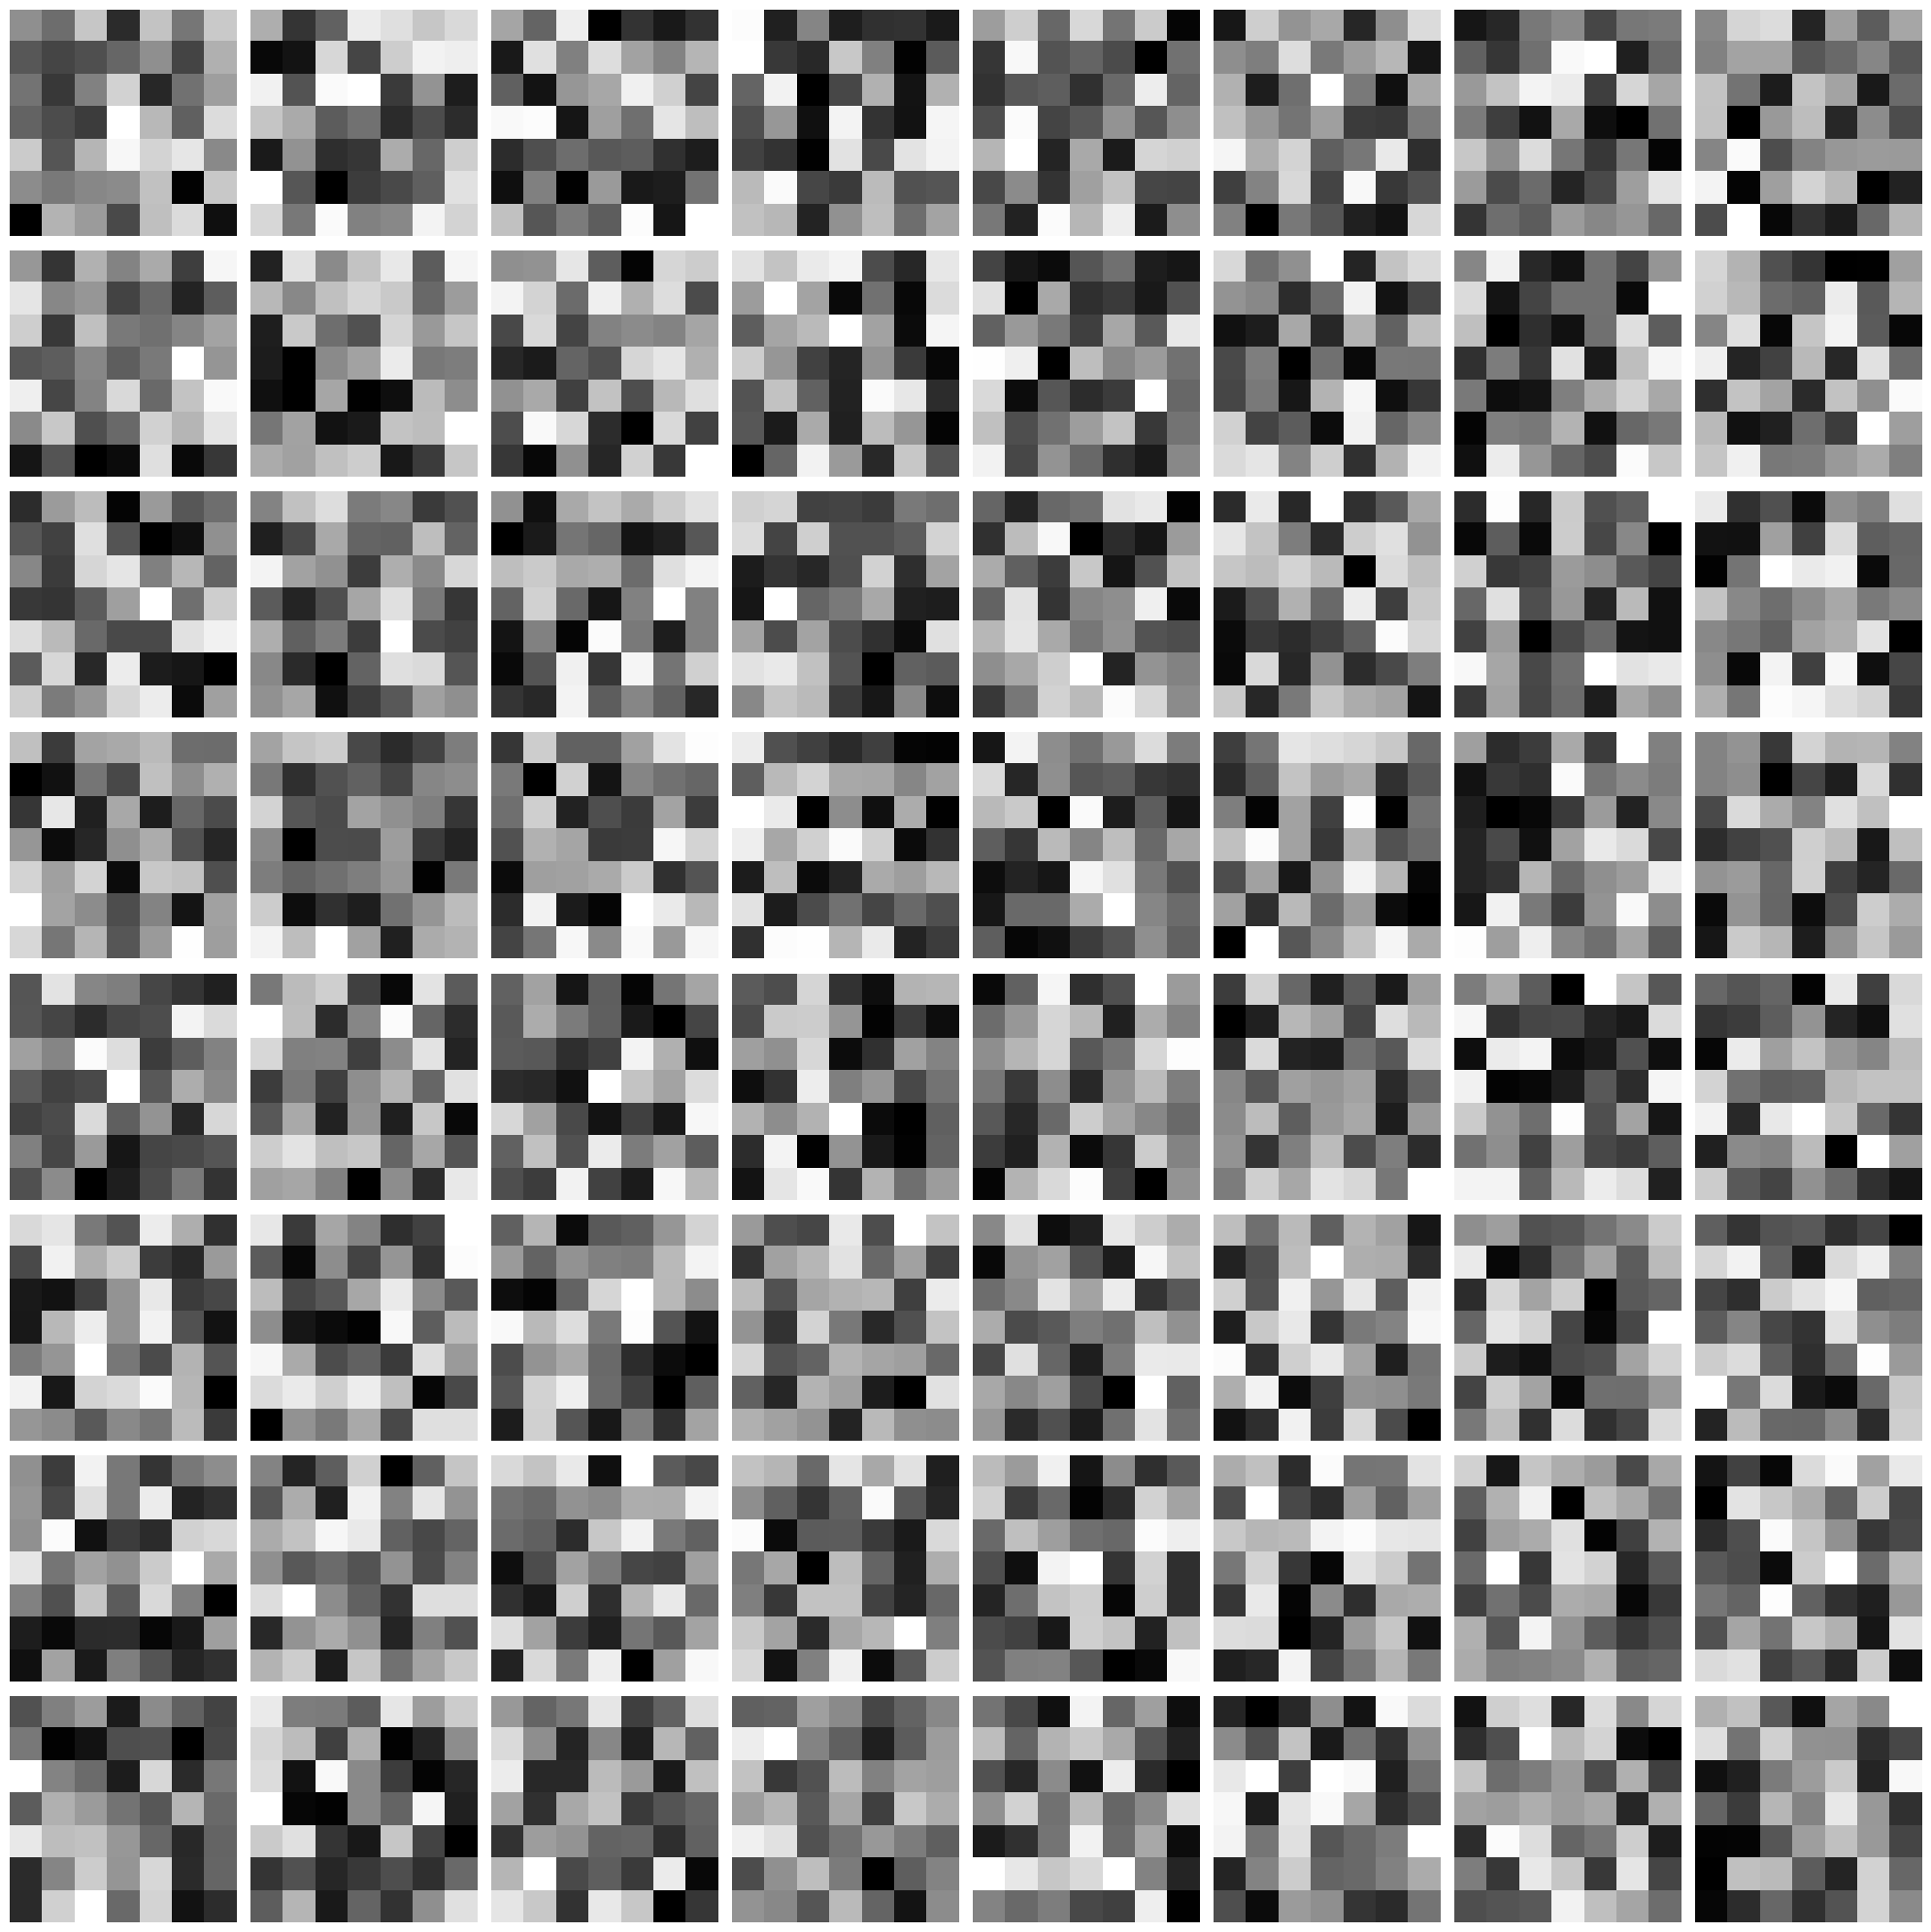

In [37]:
## Visualizar Kernels
# Obtener la primera capa convolucional
conv1_weights = model.model.conv1.weight.data
# Normalizar los pesos al rango [0, 1]
normalized_weights = (conv1_weights - conv1_weights.min()) / (conv1_weights.max() - conv1_weights.min())
# Número de filtros a visualizar
num_filters = conv1_weights.shape[0]
grid_size = int(num_filters ** 0.5)  # Aseguramos que sea cuadrada
rows, cols = grid_size, grid_size
# Graficar en una cuadrícula de 8x8
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))  # Ajusta el tamaño de la figura
for i in range(rows):
    for j in range(cols):
        filter_idx = i * cols + j
        if filter_idx < num_filters:
            ax = axes[i, j]
            ax.imshow(normalized_weights[filter_idx, 0, :, :].cpu().numpy(), cmap='gray')
            ax.axis('off')
        else:
            axes[i, j].axis('off')  # Desactiva ejes vacíos

plt.tight_layout()
plt.show()


In [73]:
# Calcular las predicciones en todo el conjunto de datos de validación y almacenar las predicciones y las etiquetas
preds = []  # Lista para almacenar las predicciones
labels = []  # Lista para almacenar las etiquetas verdaderas

# Desactivar el cálculo del gradiente, ya que no es necesario durante la evaluación
with torch.no_grad():
    for data, label in tqdm(val_dataset):  # Iterar sobre todo el conjunto de datos de validación
        data = data.to(device).float().unsqueeze(0)  # Enviar los datos al dispositivo (GPU/CPU) y añadir una dimensión extra para el lote
        pred = torch.sigmoid(model(data)[0].cpu())  # Hacer la predicción, aplicar la función sigmoide y llevar la predicción a la CPU
        preds.append(pred)  # Almacenar la predicción
        labels.append(label)  # Almacenar la etiqueta verdadera

# Convertir las listas de predicciones y etiquetas a tensores
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/2684 [00:00<?, ?it/s]

Calcular métricas:  
Podemos ver que el resultado general ya es decente con nuestro modelo simple.  
Sin embargo, sufrimos de una gran cantidad de falsos negativos debido al desequilibrio de los datos.  

Intenta probar qué sucede si aumentas o disminuyes el peso en la función de pérdida.

Una alternativa a volver a entrenar con una pérdida ponderada es reducir el umbral de clasificación de 0.5 a, por ejemplo, 0.25. Esto produce muchos menos falsos negativos, pero aumenta el número de falsos positivos.  
Esto se llama el compromiso entre precisión y sensibilidad (*precision-recall tradeoff*).

In [54]:
# Suponiendo que estás trabajando en un problema de clasificación binaria
acc = torchmetrics.Accuracy(task="binary")(preds, labels)
precision = torchmetrics.Precision(task="binary")(preds, labels)
recall = torchmetrics.Recall(task="binary")(preds, labels)

# Ajuste en la ConfusionMatrix
cm = torchmetrics.ConfusionMatrix(task="binary")(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(task="binary", threshold=0.25)(preds, labels)

# Imprimir los resultados
print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {cm}")
print(f"Confusion Matrix (Threshold=0.25):\n {cm_threshed}")

Val Accuracy: 0.8505961298942566
Val Precision: 0.7217391133308411
Val Recall: 0.5487603545188904
Confusion Matrix:
 tensor([[1951,  128],
        [ 273,  332]])
Confusion Matrix (Threshold=0.25):
 tensor([[1688,  391],
        [ 123,  482]])


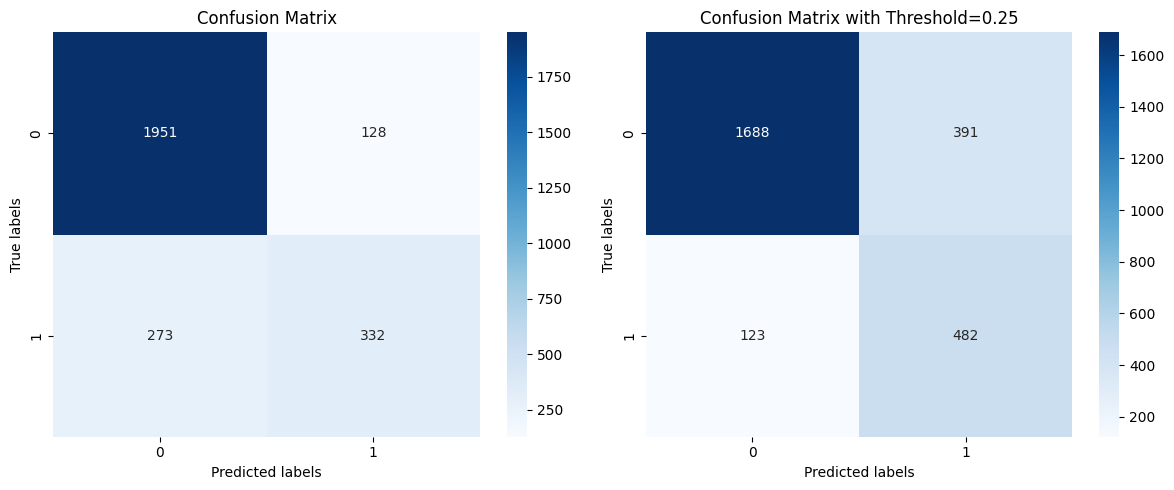

In [74]:
acc = torchmetrics.Accuracy(task="binary")(preds, labels)
precision = torchmetrics.Precision(task="binary")(preds, labels)
recall = torchmetrics.Recall(task="binary")(preds, labels)

# Calcular la matriz de confusión
cm = torchmetrics.ConfusionMatrix(task="binary")(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(task="binary", threshold=0.25)(preds, labels)

# Convertir la matriz de confusión a un formato NumPy para su visualización
cm_np = cm.cpu().numpy()
cm_threshed_np = cm_threshed.cpu().numpy()

# Visualizar la matriz de confusión
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_np, annot=True, fmt="d", cmap="Blues", ax=ax[0])
ax[0].set_title("Confusion Matrix")
ax[0].set_xlabel("Predicted labels")
ax[0].set_ylabel("True labels")

sns.heatmap(cm_threshed_np, annot=True, fmt="d", cmap="Blues", ax=ax[1])
ax[1].set_title("Confusion Matrix with Threshold=0.25")
ax[1].set_xlabel("Predicted labels")
ax[1].set_ylabel("True labels")

plt.tight_layout()
plt.show()

In [103]:
# Convertir las predicciones en etiquetas binarias (umbral en 0.5)
predicted_labels = (preds > 0.5).int()
# Identificar los índices de los falsos positivos
false_positives_indices = (predicted_labels == 1) & (labels == 0)
false_negatives_indices = (predicted_labels == 0) & (labels == 1)
false_positives_indices = false_positives_indices.nonzero(as_tuple=True)[0]
false_negatives_indices = false_negatives_indices.nonzero(as_tuple=True)[0]


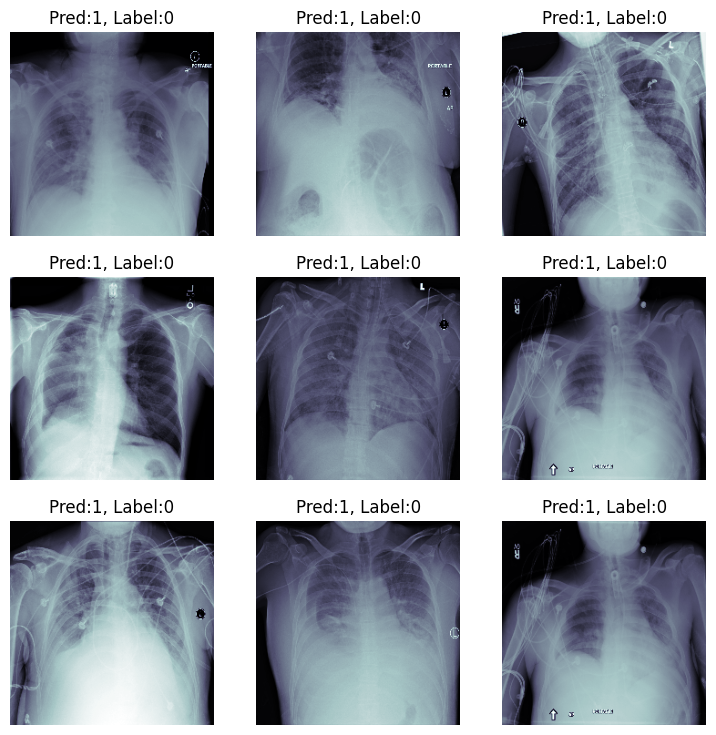

In [104]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        rnd_idx = false_positives_indices[np.random.randint(0, len(false_positives_indices))]
        axis[i][j].imshow(val_dataset[rnd_idx][0][0], cmap="bone")
        axis[i][j].set_title(f"Pred:{int(preds[rnd_idx] > 0.5)}, Label:{labels[rnd_idx]}")
        axis[i][j].axis("off")


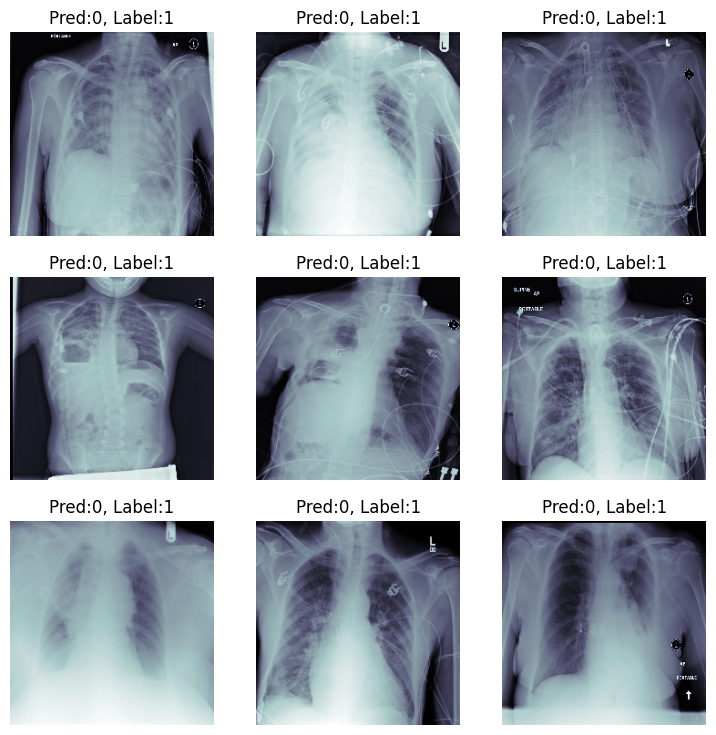

In [105]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        rnd_idx = false_negatives_indices[np.random.randint(0, len(false_negatives_indices))]
        axis[i][j].imshow(val_dataset[rnd_idx][0][0], cmap="bone")
        axis[i][j].set_title(f"Pred:{int(preds[rnd_idx] > 0.5)}, Label:{labels[rnd_idx]}")
        axis[i][j].axis("off")
